In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
import os
import copy
import math
import random

import pandas as pd
import numpy as np

# To hide OpenCV Warnings
import warnings
warnings.filterwarnings('ignore')

import cv2

from skimage.feature import hog
from skimage import data, exposure

from scipy.stats import norm
from scipy.signal import savgol_filter

import time
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
#from __future__ import print_function
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
import cv2
from transformers import data
import wandb
from sklearn.model_selection import KFold
# from torchsummary import summary
from datetime import timedelta

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-07 21:55:29.990467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 21:55:30.119997: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-07 21:55:30.145384: E tensorflow/stream_executor/cuda/cuda_blas.cc:2

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

SHAKE_PARAMETER = 50
SHAKE_PARAMETER_INDIVIDUAL = 20

In [4]:
EXPECTED_PART_LIST = ["Nose", "InnerEar", "Spine1", "Spine2", "Spine3", "Spine4", "TailStart"]
debug = False
class Node:
    '''
    Single Node in the Pose Graph.

    Parameters:
    @coordinates: x and y coordinate tuple of a part.
    @part_name: Name of the part, should be one of: 
        Nose, InnerEar, Spine1, Spine2, Spine3, Spine4, TailStart
    '''
    def __init__(self, coordinates, part_name):
        self.is_root = False
        
        self.x = coordinates[0]
        self.y = coordinates[1]

        self.edge_to = None
        self.edge_from = None
        
        self.L = None       # Distance to next node
        self.alpha = None   # Angle with next node
        
        assert part_name in EXPECTED_PART_LIST, "ERROR: " + part_name + " is not a valid part name."
        self.part = part_name

        if self.part == "TailStart":
            self.is_root = True

        if debug:
            print("DEBUG: Node " + self.part + " created! (x: " 
            + str(self.x) + ", y: " + str(self.y) + ")")
    
    def get_coordinates(self):
        return (self.x, self.y)
    
    def get_name(self):
        return part

class PoseGraph:
    '''
    Pose graph for a frame.
    
    Parameters:
    @parts: Array consisting of n parts arranged as: (x, y, part_name)
        The parts must also be in order of arrangement in the image.
    '''
    def __init__(self, parts):
        self.vertices = []
        self.edges = []
        
        self.distance_edge_to_next = []
        self.angle_edge_to_next = []

        # Node that isn't being pointed to by any other node.
        # If a node isn't pointing to anything, then it is a leaf node.
        self.root_node = None

        for i in range(len(parts)):
            # Create a Node object for the part, and add it to the
            # list of vertices
            part = Node((parts[i][0], parts[i][1]), parts[i][2])
            self.vertices.append(part)
            
            # Get the Root Node
            if part.is_root:
                self.root_node = part

            if debug:
                print("DEBUG: Added Vertex for " + part.part + " to the Pose Graph.")

            # Add a new edge if there are at least 2 vertices present
            if len(self.vertices) > 1:
                previous_part = self.vertices[-2]
                
                # Create and edge from the previous part to the current part
                previous_part.edge_to = part
                part.edge_from = previous_part
                
                self.edges.append([previous_part, part])
                
                # Add a final edge from the last part to the first part
                if len(self.vertices) == len(EXPECTED_PART_LIST):
                    part.edge_to = self.vertices[0]
                    self.vertices[0].edge_from = part
                    self.edges.append([previous_part, part])
            
                if debug:
                    print("DEBUG: Added Edge " + previous_part.part + " --> " + part.part + " to the Pose Graph.")

                    
        # Calulating the distance L and angle alpha at each part 
        # requires knowledge of the next 2 points, so it will be 
        # processed once the graph is built
        
#         def _slope(part1, part2):
#             m = (part2.y-part1.y)/(part2.x-part1.x)
#             return m

    
        for vertex in self.vertices:
            current_part = vertex
            previous_part = current_part.edge_from
            next_part = current_part.edge_to
            
            # Calculating Distance (L)
            current_part.L = math.dist(next_part.get_coordinates(), current_part.get_coordinates())
            
            # Calculating the angle (alpha)
            lineAway = [[current_part.x, current_part.y], [next_part.x, next_part.y]]
            lineInto = [[current_part.x, current_part.y], [previous_part.x, previous_part.y]]
#             m1 = _slope(next_part, current_part)
#             m2 = _slope(previous_part, current_part)
#             if m1*m2 == -1.0:
#                 current_part.alpha = 90.0   # Angle = 90
#             else:
#             angle = math.atan(abs((m2 - m1) / (1 + m1 * m2)))
            current_part.alpha = get_angle(lineAway, lineInto)
        
#         print("INFO: Create the PoseGraph with " + str(len(self.vertices)) + " vertices and " + str(len(self.edges)) + " edges.")

    def get_vertices(self):
        return self.vertices

    def get_edges(self):
        return self.edges

    def print_vertices(self):
        vertex_count = 1
        for vertex in self.vertices:
            print("Vertex " + str(vertex_count) + ": " + vertex.part 
            + "(x: " + str(vertex.x) + ", y: " + str(vertex.y) + ")")
            vertex_count += 1

    def print_edges(self):
        for edge in self.edges:
            print(edge[1].part + " --> " + edge[0].part)
            
    def get_pose_estimation(self):
        pose_estimation = []
        for vertex in self.vertices:
            pose_estimation += vertex.x, vertex.y, vertex.L, vertex.alpha
        return pose_estimation

In [5]:
datapoints = pd.read_hdf("/media/data_cifs/anagara8/FC-D_6394846-Akash-2022-10-19/videos/video_2019Y_06M_07D_09h_14m_27s_cam_6394846-0000_pcDLC_resnet50_FC-D_6394846Oct19shuffle1_250000.h5")
datapoints.iloc[0]

scorer                                         bodyparts  coords    
DLC_resnet50_FC-D_6394846Oct19shuffle1_250000  Nose       x             386.184448
                                                          y             359.902924
                                                          likelihood      0.992119
                                               InnerEar   x             386.133392
                                                          y             343.611328
                                                          likelihood      0.997565
                                               Spine1     x             405.477356
                                                          y             339.301178
                                                          likelihood      0.998041
                                               Spine2     x             414.024109
                                                          y             342.719299
                  

In [7]:
datapoints = pd.read_hdf("/media/data_cifs/anagara8/FC-D_6394846-Akash-2022-10-19/videos/video_2019Y_06M_07D_10h_14m_28s_cam_6394846-0000DLC_resnet50_FC-D_6394846Oct19shuffle1_250000.h5")
dataframe_reference = "DLC_resnet50_FC-D_6394846Oct19shuffle1_250000"
# pc: /media/data_cifs/anagara8/FC-A_17202338-Akash-2022-10-02/videos/video_2018Y_08M_13D_10h_01m_38s_cam_17202338-0000_pcDLC_resnet50_FC-A_17202338Oct2shuffle2_500000.h5

number_of_datapoints = int(len(datapoints)/100) - 100
print("#Datapoints:", number_of_datapoints)

nose_x = [None]*number_of_datapoints
nose_y = [None]*number_of_datapoints

innerear_x = [None]*number_of_datapoints
innerear_y = [None]*number_of_datapoints

spine1_x = [None]*number_of_datapoints
spine1_y = [None]*number_of_datapoints

spine2_x = [None]*number_of_datapoints
spine2_y = [None]*number_of_datapoints

spine3_x = [None]*number_of_datapoints
spine3_y = [None]*number_of_datapoints

spine4_x = [None]*number_of_datapoints
spine4_y = [None]*number_of_datapoints

tailstart_x = [None]*number_of_datapoints
tailstart_y = [None]*number_of_datapoints
#######################################################
previous_nose_x = 0
previous_nose_y = 0

previous_innerear_x = 0
previous_innerear_y = 0

previous_spine1_x = 0
previous_spine1_y = 0

previous_spine2_x = 0
previous_spine2_y = 0

previous_spine3_x = 0
previous_spine3_y = 0

previous_spine4_x = 0
previous_spine4_y = 0

previous_tailstart_x = 0
previous_tailstart_y = 0

#Datapoints: 980


In [8]:
# Smoothing based on previous frames:
print("Iterating Dataframe...")
unsure_point_count = 0
for idx in range(0, number_of_datapoints):

    nose_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Nose']['x'])
    nose_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Nose']['y'])
    if  not abs(nose_x[idx] - previous_nose_x) > SHAKE_PARAMETER_INDIVIDUAL:
        nose_x[idx] = previous_nose_x
    else:
        previous_nose_x = nose_x[idx]
    if  not abs(nose_y[idx] - previous_nose_y) > SHAKE_PARAMETER_INDIVIDUAL:
        nose_y[idx] = previous_nose_y
    else:
        previous_nose_y = nose_y[idx]
    
    innerear_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['InnerEar']['x'])
    innerear_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['InnerEar']['y'])
    if  not abs(innerear_x[idx] - previous_innerear_x) > SHAKE_PARAMETER_INDIVIDUAL:
        innerear_x[idx] = previous_innerear_x
    else:
        previous_innerear_x = innerear_x[idx]
    if  not abs(innerear_y[idx] - previous_innerear_y) > SHAKE_PARAMETER_INDIVIDUAL:
        innerear_y[idx] = previous_innerear_y
    else:
        previous_innerear_y = innerear_y[idx]

    spine1_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine1']['x'])
    spine1_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine1']['y'])  
    if  not abs(spine1_x[idx] - previous_spine1_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine1_x[idx] = previous_spine1_x
    else:
        previous_spine1_x = spine1_x[idx]
    if  not abs(spine1_y[idx] - previous_spine1_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine1_y[idx] = previous_spine1_y
    else:
        previous_spine1_y = spine1_y[idx]
        
    spine2_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine2']['x'])
    spine2_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine2']['y'])    
    if  not abs(spine2_x[idx] - previous_spine2_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine2_x[idx] = previous_spine2_x
    else:
        previous_spine2_x = spine2_x[idx]
    if  not abs(spine2_y[idx] - previous_spine2_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine2_y[idx] = previous_spine2_y
    else:
        previous_spine2_y = spine2_y[idx]

    spine3_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine3']['x'])
    spine3_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine3']['y'])
    if  not abs(spine3_x[idx] - previous_spine3_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine3_x[idx] = previous_spine3_x
    else:
        previous_spine3_x = spine3_x[idx]
    if  not abs(spine3_y[idx] - previous_spine3_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine3_y[idx] = previous_spine3_y
    else:
        previous_spine3_y = spine3_y[idx]

    spine4_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine4']['x'])
    spine4_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine4']['y'])
    if  not abs(spine4_x[idx] - previous_spine4_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine4_x[idx] = previous_spine4_x
    else:
        previous_spine4_x = spine4_x[idx]
    if  not abs(spine4_y[idx] - previous_spine4_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine4_y[idx] = previous_spine4_y
    else:
        previous_spine4_y = spine4_y[idx]

    tailstart_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['TailStart']['x'])
    tailstart_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['TailStart']['y'])
    if  not abs(tailstart_x[idx] - previous_tailstart_x) > SHAKE_PARAMETER_INDIVIDUAL:
        tailstart_x[idx] = previous_tailstart_x
    else:
        previous_tailstart_x = tailstart_x[idx]
    if  not abs(tailstart_y[idx] - previous_tailstart_y) > SHAKE_PARAMETER_INDIVIDUAL:
        tailstart_y[idx] = previous_tailstart_y
    else:
        previous_tailstart_y = tailstart_y[idx]
print("Done!")

Iterating Dataframe...
Done!


In [9]:
print("Smoothing Individual Points...")
# Smoothing Individual Parts
smooth_nose_x = [int(x) for x in savgol_filter(nose_x, 15, 3, mode='nearest')]
smooth_nose_y = [int(y) for y in savgol_filter(nose_y, 15, 3, mode='nearest')]

smooth_innerear_x = [int(x) for x in savgol_filter(innerear_x, 15, 3, mode='nearest')]
smooth_innerear_y = [int(y) for y in savgol_filter(innerear_y, 15, 3, mode='nearest')]

smooth_spine1_x = [int(x) for x in savgol_filter(spine1_x, 15, 3, mode='nearest')]
smooth_spine1_y = [int(y) for y in savgol_filter(spine1_y, 15, 3, mode='nearest')]

smooth_spine2_x = [int(x) for x in savgol_filter(spine2_x, 15, 3, mode='nearest')]
smooth_spine2_y = [int(y) for y in savgol_filter(spine2_y, 15, 3, mode='nearest')]

smooth_spine3_x = [int(x) for x in savgol_filter(spine3_x, 15, 3, mode='nearest')]
smooth_spine3_y = [int(y) for y in savgol_filter(spine3_y, 15, 3, mode='nearest')]

smooth_spine4_x = [int(x) for x in savgol_filter(spine4_x, 15, 3, mode='nearest')]
smooth_spine4_y = [int(y) for y in savgol_filter(spine4_y, 15, 3, mode='nearest')]

smooth_tailstart_x = [int(x) for x in savgol_filter(tailstart_x, 15, 3, mode='nearest')]
smooth_tailstart_y = [int(y) for y in savgol_filter(tailstart_y, 15, 3, mode='nearest')]
print("Done Smoothing Points!")

Smoothing Individual Points...
Done Smoothing Points!


In [25]:
data_list = []
no_append_count = 0
previous_part_x = {"Nose":0.0, "InnerEar":0.0, "Spine1":0.0, "Spine2":0.0, "Spine3":0.0, "Spine4":0.0, "TailStart":0.0}
previous_part_y = {"Nose":0.0, "InnerEar":0.0, "Spine1":0.0, "Spine2":0.0, "Spine3":0.0, "Spine4":0.0, "TailStart":0.0}

print("Iterating Dataframe...")
for idx in range(0, int(number_of_datapoints)):
    part_list = []
#     for part in EXPECTED_PART_LIST:
#         part_x = float(datapoints.iloc[idx][dataframe_reference][part]['x'])
#         part_y = float(datapoints.iloc[idx][dataframe_reference][part]['y'])
#         if  not abs(part_x - previous_part_x[part]) > SHAKE_PARAMETER_INDIVIDUAL:
#             part_x = previous_part_x[part]
#         else:
#             previous_part_x[part] = part_x
            
#         if  not abs(part_y - previous_part_y[part]) > SHAKE_PARAMETER_INDIVIDUAL:
#             part_y = previous_part_y[part]
#         else:
#             previous_part_y[part] = part_y

    part_list.append([smooth_nose_x[idx], smooth_nose_y[idx], "Nose"])
    part_list.append([smooth_innerear_x[idx], smooth_innerear_y[idx], "InnerEar"])
    part_list.append([smooth_spine1_x[idx], smooth_spine1_y[idx], "Spine1"])
    part_list.append([smooth_spine2_x[idx], smooth_spine2_y[idx], "Spine2"])
    part_list.append([smooth_spine3_x[idx], smooth_spine3_y[idx], "Spine3"])
    part_list.append([smooth_spine4_x[idx], smooth_spine4_y[idx], "Spine4"])
    part_list.append([smooth_tailstart_x[idx], smooth_tailstart_y[idx], "TailStart"])
            
#         part_list.append([part_x, part_y, "Nose"])
    try:
        data_list.append([smooth_nose_x[idx], smooth_nose_y[idx], 
                          smooth_innerear_x[idx], smooth_innerear_y[idx], 
                          smooth_spine1_x[idx], smooth_spine1_y[idx],
                          smooth_spine2_x[idx], smooth_spine2_y[idx],
                          smooth_spine3_x[idx], smooth_spine3_y[idx],
                          smooth_spine4_x[idx], smooth_spine4_y[idx],
                          smooth_tailstart_x[idx], smooth_tailstart_y[idx]
                         ])
    except:
        no_append_count += 1
        print("Didn't append for index", idx, part_list)

print("Didn't append for a total of "+str(no_append_count)+" rows.")
print("Done!\n")

Iterating Dataframe...
Didn't append for a total of 0 rows.
Done!



In [26]:
data_list[0]

[585, 233, 555, 258, 546, 287, 541, 314, 531, 340, 518, 363, 506, 390]

In [12]:
data_list_x4 = []
data_list_y4 = []
areas4 = []

In [13]:

no_append_count = 0
# previous_part_x = {"Nose":0.0, "InnerEar":0.0, "Spine1":0.0, "Spine2":0.0, "Spine3":0.0, "Spine4":0.0, "TailStart":0.0}
# previous_part_y = {"Nose":0.0, "InnerEar":0.0, "Spine1":0.0, "Spine2":0.0, "Spine3":0.0, "Spine4":0.0, "TailStart":0.0}

def shoelace_area(x_list,y_list):
    a1, a2=0, 0
    x_list.append(x_list[0])
    y_list.append(y_list[0])
    for j in range(len(x_list)-1):
        a1 += x_list[j]*y_list[j+1]
        a2 += y_list[j]*x_list[j+1]
    l=abs(a1-a2)/2
    return l

print("Iterating Dataframe...")
for idx in range(0, int(number_of_datapoints)):
#     part_list = []
#     for part in EXPECTED_PART_LIST:
#         part_x = float(datapoints.iloc[idx][dataframe_reference][part]['x'])
#         part_y = float(datapoints.iloc[idx][dataframe_reference][part]['y'])
#         if  not abs(part_x - previous_part_x[part]) > SHAKE_PARAMETER_INDIVIDUAL:
#             part_x = previous_part_x[part]
#         else:
#             previous_part_x[part] = part_x
            
#         if  not abs(part_y - previous_part_y[part]) > SHAKE_PARAMETER_INDIVIDUAL:
#             part_y = previous_part_y[part]
#         else:
#             previous_part_y[part] = part_y
    x_list = [smooth_nose_x[idx], smooth_innerear_x[idx], smooth_spine1_x[idx], smooth_spine2_x[idx], smooth_spine3_x[idx], smooth_spine4_x[idx], smooth_tailstart_x[idx]]
    y_list = [smooth_nose_y[idx], smooth_innerear_y[idx], smooth_spine1_y[idx], smooth_spine2_y[idx], smooth_spine3_y[idx], smooth_spine4_y[idx], smooth_tailstart_y[idx]]
    data_list_x4.append(x_list)
    data_list_y4.append(y_list)
#     part_list.append([smooth_nose_x[idx], smooth_nose_y[idx], "Nose"])
#     part_list.append([smooth_innerear_x[idx], smooth_innerear_y[idx], "InnerEar"])
#     part_list.append([smooth_spine1_x[idx], smooth_spine1_y[idx], "Spine1"])
#     part_list.append([smooth_spine2_x[idx], smooth_spine2_y[idx], "Spine2"])
#     part_list.append([smooth_spine3_x[idx], smooth_spine3_y[idx], "Spine3"])
#     part_list.append([smooth_spine4_x[idx], smooth_spine4_y[idx], "Spine4"])
#     part_list.append([smooth_tailstart_x[idx], smooth_tailstart_y[idx], "TailStart"])
    
#         part_list.append([part_x, part_y, "Nose"])
#     try:
#         data_list.append(PoseGraph(part_list).get_pose_estimation())
#     except:
#         no_append_count += 1
#         print("Didn't append for index", idx, part_list)
    areas4.append(shoelace_area(x_list, y_list))
print("Didn't append for a total of "+str(no_append_count)+" rows.")
print("Done!\n")

Iterating Dataframe...
Didn't append for a total of 0 rows.
Done!



In [260]:
len(areas2)

215800

<AxesSubplot:>

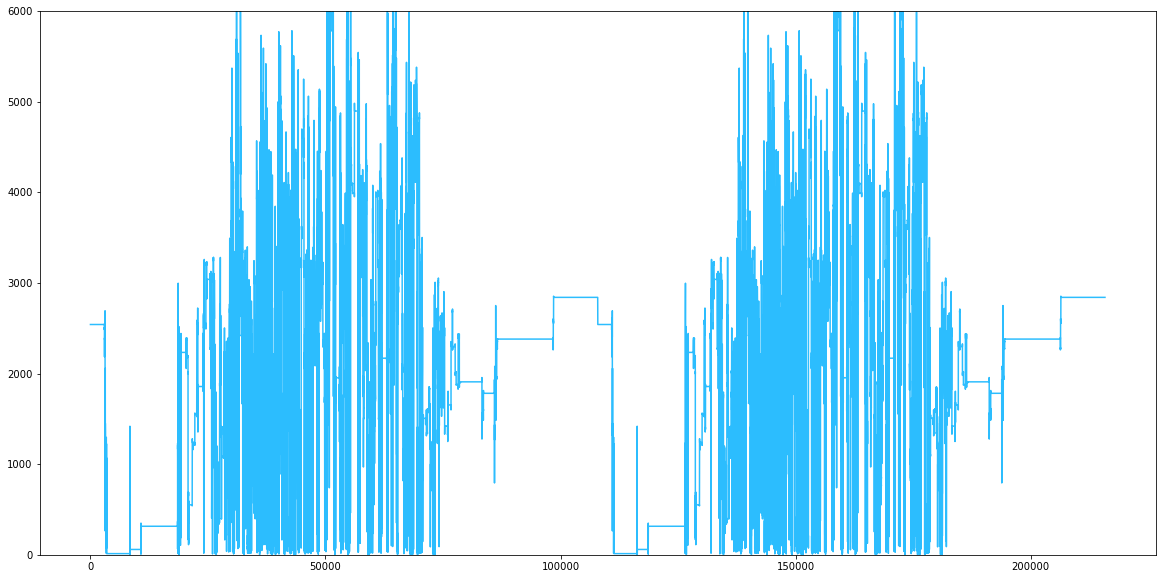

In [277]:
plt.figure(figsize=(20,10))
plt.ylim([0, 6000])
import seaborn
seaborn.lineplot(range(len(areas)), areas3, color="#2CBDFE")

ValueError: All arrays must be of the same length

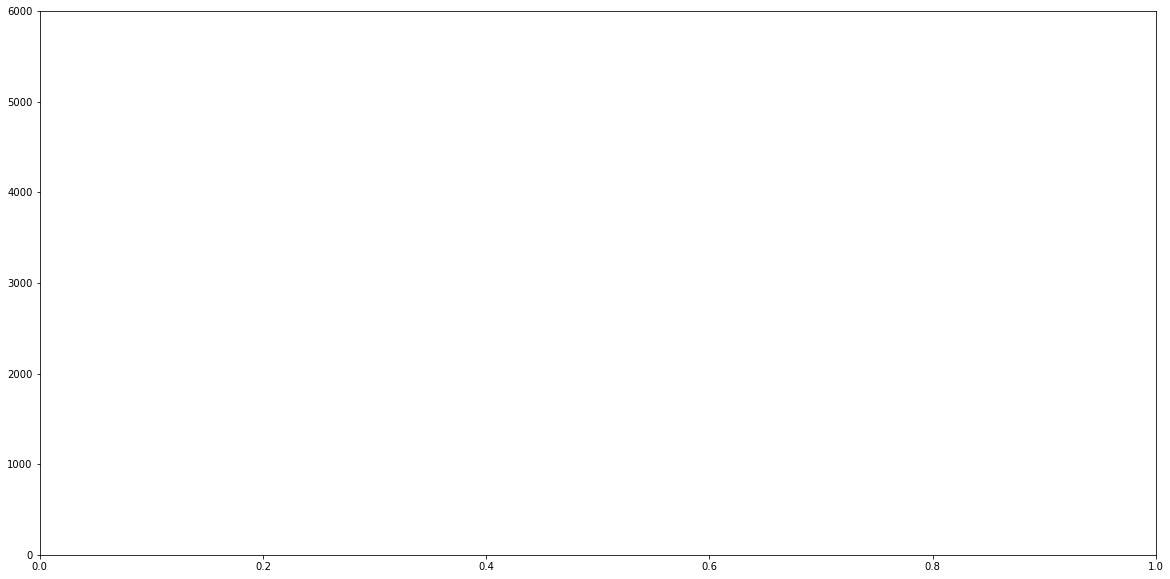

In [270]:
temp = [int(x) for x in savgol_filter(areas3, 1500, 3, mode='nearest')]
plt.figure(figsize=(20,10))
plt.ylim([0, 6000])
import seaborn
seaborn.lineplot(range(len(areas)), temp, color="#2CBDFE")

<AxesSubplot:>

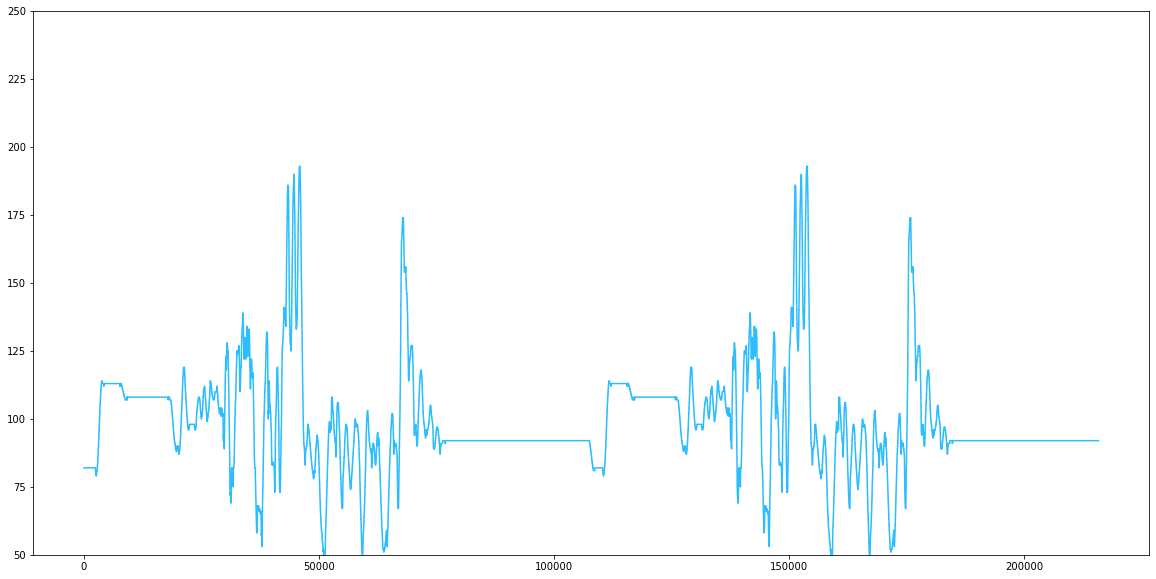

In [278]:
temp = [int(x) for x in savgol_filter([480-i[0] for i in data_list_y3], 1500, 3, mode='nearest')]
plt.figure(figsize=(20,10))
plt.ylim([50, 250])
import seaborn
seaborn.lineplot(range(len(temp)), temp, color="#2CBDFE")

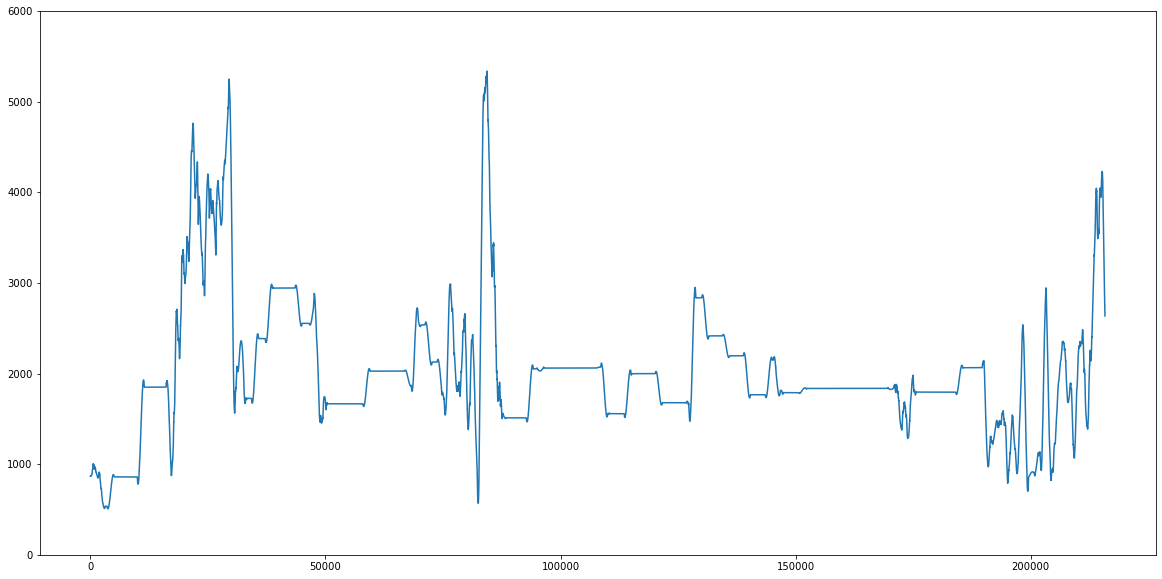

In [293]:
temp = [int(x) for x in savgol_filter(areas4, 1500, 3, mode='nearest')]
plt.figure(figsize=(20,10))
plt.ylim([0, 6000])
plt.plot(range(len(areas2)), temp)

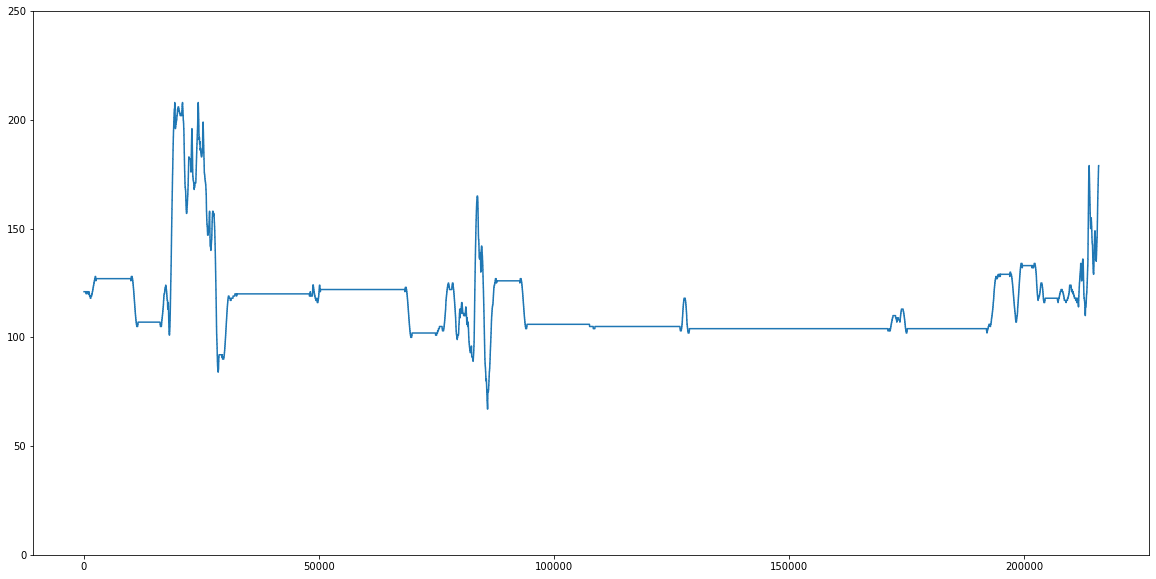

In [294]:
temp = [int(x) for x in savgol_filter([480-i[0] for i in data_list_y4], 1500, 3, mode='nearest')]
plt.figure(figsize=(20,10))
plt.ylim([0, 250])
plt.plot(range(len(data_list_y2)), temp)

In [176]:
data_list_x2 = []
data_list_y2 = []
areas2 = []
no_append_count = 0
# previous_part_x = {"Nose":0.0, "InnerEar":0.0, "Spine1":0.0, "Spine2":0.0, "Spine3":0.0, "Spine4":0.0, "TailStart":0.0}
# previous_part_y = {"Nose":0.0, "InnerEar":0.0, "Spine1":0.0, "Spine2":0.0, "Spine3":0.0, "Spine4":0.0, "TailStart":0.0}

def shoelace_area(x_list,y_list):
    a1, a2=0, 0
    x_list.append(x_list[0])
    y_list.append(y_list[0])
    for j in range(len(x_list)-1):
        a1 += x_list[j]*y_list[j+1]
        a2 += y_list[j]*x_list[j+1]
    l=abs(a1-a2)/2
    return l

print("Iterating Dataframe...")
for idx in range(0, int(number_of_datapoints)):
#     part_list = []
#     for part in EXPECTED_PART_LIST:
#         part_x = float(datapoints.iloc[idx][dataframe_reference][part]['x'])
#         part_y = float(datapoints.iloc[idx][dataframe_reference][part]['y'])
#         if  not abs(part_x - previous_part_x[part]) > SHAKE_PARAMETER_INDIVIDUAL:
#             part_x = previous_part_x[part]
#         else:
#             previous_part_x[part] = part_x
            
#         if  not abs(part_y - previous_part_y[part]) > SHAKE_PARAMETER_INDIVIDUAL:
#             part_y = previous_part_y[part]
#         else:
#             previous_part_y[part] = part_y
    x_list = [smooth_nose_x[idx], smooth_innerear_x[idx], smooth_spine1_x[idx], smooth_spine2_x[idx], smooth_spine3_x[idx], smooth_spine4_x[idx], smooth_tailstart_x[idx]]
    y_list = [smooth_nose_y[idx], smooth_innerear_y[idx], smooth_spine1_y[idx], smooth_spine2_y[idx], smooth_spine3_y[idx], smooth_spine4_y[idx], smooth_tailstart_y[idx]]
    data_list_x2.append(x_list)
    data_list_y2.append(y_list)
#     part_list.append([smooth_nose_x[idx], smooth_nose_y[idx], "Nose"])
#     part_list.append([smooth_innerear_x[idx], smooth_innerear_y[idx], "InnerEar"])
#     part_list.append([smooth_spine1_x[idx], smooth_spine1_y[idx], "Spine1"])
#     part_list.append([smooth_spine2_x[idx], smooth_spine2_y[idx], "Spine2"])
#     part_list.append([smooth_spine3_x[idx], smooth_spine3_y[idx], "Spine3"])
#     part_list.append([smooth_spine4_x[idx], smooth_spine4_y[idx], "Spine4"])
#     part_list.append([smooth_tailstart_x[idx], smooth_tailstart_y[idx], "TailStart"])
    
#         part_list.append([part_x, part_y, "Nose"])
#     try:
#         data_list.append(PoseGraph(part_list).get_pose_estimation())
#     except:
#         no_append_count += 1
#         print("Didn't append for index", idx, part_list)
    areas2.append(shoelace_area(x_list, y_list))
print("Didn't append for a total of "+str(no_append_count)+" rows.")
print("Done!\n")

Iterating Dataframe...
Didn't append for a total of 0 rows.
Done!



In [14]:
datapoints = pd.read_hdf("/media/data_cifs/anagara8/FC-A_17202338-Akash-2022-10-02/videos/video_2018Y_08M_13D_10h_01m_38s_cam_17202338-0000_pcDLC_resnet50_FC-A_17202338Oct2shuffle2_500000.h5")
dataframe_reference = "DLC_resnet50_FC-A_17202338Oct2shuffle2_500000"
# pc: 

number_of_datapoints = int(len(datapoints)/100) - 100
print("#Datapoints:", number_of_datapoints)

nose_x = [None]*number_of_datapoints
nose_y = [None]*number_of_datapoints

innerear_x = [None]*number_of_datapoints
innerear_y = [None]*number_of_datapoints

spine1_x = [None]*number_of_datapoints
spine1_y = [None]*number_of_datapoints

spine2_x = [None]*number_of_datapoints
spine2_y = [None]*number_of_datapoints

spine3_x = [None]*number_of_datapoints
spine3_y = [None]*number_of_datapoints

spine4_x = [None]*number_of_datapoints
spine4_y = [None]*number_of_datapoints

tailstart_x = [None]*number_of_datapoints
tailstart_y = [None]*number_of_datapoints
#######################################################
previous_nose_x = 0
previous_nose_y = 0

previous_innerear_x = 0
previous_innerear_y = 0

previous_spine1_x = 0
previous_spine1_y = 0

previous_spine2_x = 0
previous_spine2_y = 0

previous_spine3_x = 0
previous_spine3_y = 0

previous_spine4_x = 0
previous_spine4_y = 0

previous_tailstart_x = 0
previous_tailstart_y = 0

#Datapoints: 980


In [24]:
# Smoothing based on previous frames:
print("Iterating Dataframe...")
unsure_point_count = 0
for idx in range(0, number_of_datapoints):

    nose_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Nose']['x'])
    nose_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Nose']['y'])
    if  not abs(nose_x[idx] - previous_nose_x) > SHAKE_PARAMETER_INDIVIDUAL:
        nose_x[idx] = previous_nose_x
    else:
        previous_nose_x = nose_x[idx]
    if  not abs(nose_y[idx] - previous_nose_y) > SHAKE_PARAMETER_INDIVIDUAL:
        nose_y[idx] = previous_nose_y
    else:
        previous_nose_y = nose_y[idx]
    
    innerear_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['InnerEar']['x'])
    innerear_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['InnerEar']['y'])
    if  not abs(innerear_x[idx] - previous_innerear_x) > SHAKE_PARAMETER_INDIVIDUAL:
        innerear_x[idx] = previous_innerear_x
    else:
        previous_innerear_x = innerear_x[idx]
    if  not abs(innerear_y[idx] - previous_innerear_y) > SHAKE_PARAMETER_INDIVIDUAL:
        innerear_y[idx] = previous_innerear_y
    else:
        previous_innerear_y = innerear_y[idx]

    spine1_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine1']['x'])
    spine1_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine1']['y'])  
    if  not abs(spine1_x[idx] - previous_spine1_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine1_x[idx] = previous_spine1_x
    else:
        previous_spine1_x = spine1_x[idx]
    if  not abs(spine1_y[idx] - previous_spine1_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine1_y[idx] = previous_spine1_y
    else:
        previous_spine1_y = spine1_y[idx]
        
    spine2_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine2']['x'])
    spine2_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine2']['y'])    
    if  not abs(spine2_x[idx] - previous_spine2_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine2_x[idx] = previous_spine2_x
    else:
        previous_spine2_x = spine2_x[idx]
    if  not abs(spine2_y[idx] - previous_spine2_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine2_y[idx] = previous_spine2_y
    else:
        previous_spine2_y = spine2_y[idx]

    spine3_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine3']['x'])
    spine3_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine3']['y'])
    if  not abs(spine3_x[idx] - previous_spine3_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine3_x[idx] = previous_spine3_x
    else:
        previous_spine3_x = spine3_x[idx]
    if  not abs(spine3_y[idx] - previous_spine3_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine3_y[idx] = previous_spine3_y
    else:
        previous_spine3_y = spine3_y[idx]

    spine4_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine4']['x'])
    spine4_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine4']['y'])
    if  not abs(spine4_x[idx] - previous_spine4_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine4_x[idx] = previous_spine4_x
    else:
        previous_spine4_x = spine4_x[idx]
    if  not abs(spine4_y[idx] - previous_spine4_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine4_y[idx] = previous_spine4_y
    else:
        previous_spine4_y = spine4_y[idx]

    tailstart_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['TailStart']['x'])
    tailstart_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['TailStart']['y'])
    if  not abs(tailstart_x[idx] - previous_tailstart_x) > SHAKE_PARAMETER_INDIVIDUAL:
        tailstart_x[idx] = previous_tailstart_x
    else:
        previous_tailstart_x = tailstart_x[idx]
    if  not abs(tailstart_y[idx] - previous_tailstart_y) > SHAKE_PARAMETER_INDIVIDUAL:
        tailstart_y[idx] = previous_tailstart_y
    else:
        previous_tailstart_y = tailstart_y[idx]
print("Done!")

Iterating Dataframe...
Done!


In [16]:
print("Smoothing Individual Points...")
# Smoothing Individual Parts
smooth_nose_x = [int(x) for x in savgol_filter(nose_x, 15, 3, mode='nearest')]
smooth_nose_y = [int(y) for y in savgol_filter(nose_y, 15, 3, mode='nearest')]

smooth_innerear_x = [int(x) for x in savgol_filter(innerear_x, 15, 3, mode='nearest')]
smooth_innerear_y = [int(y) for y in savgol_filter(innerear_y, 15, 3, mode='nearest')]

smooth_spine1_x = [int(x) for x in savgol_filter(spine1_x, 15, 3, mode='nearest')]
smooth_spine1_y = [int(y) for y in savgol_filter(spine1_y, 15, 3, mode='nearest')]

smooth_spine2_x = [int(x) for x in savgol_filter(spine2_x, 15, 3, mode='nearest')]
smooth_spine2_y = [int(y) for y in savgol_filter(spine2_y, 15, 3, mode='nearest')]

smooth_spine3_x = [int(x) for x in savgol_filter(spine3_x, 15, 3, mode='nearest')]
smooth_spine3_y = [int(y) for y in savgol_filter(spine3_y, 15, 3, mode='nearest')]

smooth_spine4_x = [int(x) for x in savgol_filter(spine4_x, 15, 3, mode='nearest')]
smooth_spine4_y = [int(y) for y in savgol_filter(spine4_y, 15, 3, mode='nearest')]

smooth_tailstart_x = [int(x) for x in savgol_filter(tailstart_x, 15, 3, mode='nearest')]
smooth_tailstart_y = [int(y) for y in savgol_filter(tailstart_y, 15, 3, mode='nearest')]
print("Done Smoothing Points!")

Smoothing Individual Points...
Done Smoothing Points!


In [17]:
# Smoothing based on previous frames:
print("Iterating Dataframe...")
unsure_point_count = 0
for idx in range(0, number_of_datapoints):

    nose_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Nose']['x'])
    nose_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Nose']['y'])
    if  not abs(nose_x[idx] - previous_nose_x) > SHAKE_PARAMETER_INDIVIDUAL:
        nose_x[idx] = previous_nose_x
    else:
        previous_nose_x = nose_x[idx]
    if  not abs(nose_y[idx] - previous_nose_y) > SHAKE_PARAMETER_INDIVIDUAL:
        nose_y[idx] = previous_nose_y
    else:
        previous_nose_y = nose_y[idx]
    
    innerear_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['InnerEar']['x'])
    innerear_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['InnerEar']['y'])
    if  not abs(innerear_x[idx] - previous_innerear_x) > SHAKE_PARAMETER_INDIVIDUAL:
        innerear_x[idx] = previous_innerear_x
    else:
        previous_innerear_x = innerear_x[idx]
    if  not abs(innerear_y[idx] - previous_innerear_y) > SHAKE_PARAMETER_INDIVIDUAL:
        innerear_y[idx] = previous_innerear_y
    else:
        previous_innerear_y = innerear_y[idx]

    spine1_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine1']['x'])
    spine1_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine1']['y'])  
    if  not abs(spine1_x[idx] - previous_spine1_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine1_x[idx] = previous_spine1_x
    else:
        previous_spine1_x = spine1_x[idx]
    if  not abs(spine1_y[idx] - previous_spine1_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine1_y[idx] = previous_spine1_y
    else:
        previous_spine1_y = spine1_y[idx]
        
    spine2_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine2']['x'])
    spine2_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine2']['y'])    
    if  not abs(spine2_x[idx] - previous_spine2_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine2_x[idx] = previous_spine2_x
    else:
        previous_spine2_x = spine2_x[idx]
    if  not abs(spine2_y[idx] - previous_spine2_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine2_y[idx] = previous_spine2_y
    else:
        previous_spine2_y = spine2_y[idx]

    spine3_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine3']['x'])
    spine3_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine3']['y'])
    if  not abs(spine3_x[idx] - previous_spine3_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine3_x[idx] = previous_spine3_x
    else:
        previous_spine3_x = spine3_x[idx]
    if  not abs(spine3_y[idx] - previous_spine3_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine3_y[idx] = previous_spine3_y
    else:
        previous_spine3_y = spine3_y[idx]

    spine4_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine4']['x'])
    spine4_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine4']['y'])
    if  not abs(spine4_x[idx] - previous_spine4_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine4_x[idx] = previous_spine4_x
    else:
        previous_spine4_x = spine4_x[idx]
    if  not abs(spine4_y[idx] - previous_spine4_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine4_y[idx] = previous_spine4_y
    else:
        previous_spine4_y = spine4_y[idx]

    tailstart_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['TailStart']['x'])
    tailstart_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['TailStart']['y'])
    if  not abs(tailstart_x[idx] - previous_tailstart_x) > SHAKE_PARAMETER_INDIVIDUAL:
        tailstart_x[idx] = previous_tailstart_x
    else:
        previous_tailstart_x = tailstart_x[idx]
    if  not abs(tailstart_y[idx] - previous_tailstart_y) > SHAKE_PARAMETER_INDIVIDUAL:
        tailstart_y[idx] = previous_tailstart_y
    else:
        previous_tailstart_y = tailstart_y[idx]
print("Done!")

Iterating Dataframe...
Done!


In [18]:
# Polygon
parts = [[402, 401, 'Nose'], [410, 359, 'InnerEar'], [427, 345, 'Spine1'], [444, 331, 'Spine2'], [470, 338, 'Spine3'], [487, 355, 'Spine4'], [495, 373, 'TailStart']]
polygon = []
for part in parts:
    polygon.append([part[0], part[1]])
print(polygon)

def explode_xy(xy):
    xl=[]
    yl=[]
    for i in range(len(xy)):
        xl.append(xy[i][0])
        yl.append(xy[i][1])
    return xl,yl

def shoelace_area(x_list,y_list):
    a1, a2=0, 0
    x_list.append(x_list[0])
    y_list.append(y_list[0])
    for j in range(len(x_list)-1):
        a1 += x_list[j]*y_list[j+1]
        a2 += y_list[j]*x_list[j+1]
    l=abs(a1-a2)/2
    return l

xy_e=explode_xy(polygon)

A=shoelace_area(xy_e[0],xy_e[1])
print(A)

[[402, 401], [410, 359], [427, 345], [444, 331], [470, 338], [487, 355], [495, 373]]
3721.5


In [19]:
# Gradient Flow
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
#         p = p.detach().cpu()
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu().numpy())
#     plt.figure(figsize=(15, 15))
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
#     plt.ylim(ymin=0, ymax=5)
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [27]:
class Pose_Dataset(torch.utils.data.Dataset):
    def __init__(self, pose_list, augmentations = None):
        super(Pose_Dataset, self).__init__()
        self.pose_list = pose_list
        self.augmentations = augmentations
        
        self.ONLY_SPINE_FRAME = 224
        self.distance_normalizer = 150.0
        self.angle_normalizer = 90.0
    
    def __len__(self):
        return len(self.pose_list)

    def __getitem__(self, idx):
        # Creating a copy to avoid changing the values
        current_pose = copy.copy(self.pose_list[idx])
        # Removing Location information by centering
#         spine1_x = pose[8]
#         spine1_y = pose[9]
#         spine2_x = pose[12]
#         spine2_y = pose[13]
        only_spine_normalization_x = (current_pose[12]+current_pose[8])/2 - (self.ONLY_SPINE_FRAME/2)
        only_spine_normalization_y = (current_pose[13]+current_pose[9])/2 - (self.ONLY_SPINE_FRAME/2)

#         Normalizing Pose:
        for i in range(28):
            if i % 4 == 0:
                current_pose[i] = (current_pose[i] - only_spine_normalization_x)/self.ONLY_SPINE_FRAME
            elif (i-1) % 4 == 0:
                current_pose[i] = (current_pose[i] - only_spine_normalization_y)/self.ONLY_SPINE_FRAME
            elif (i-2) % 4 == 0:
                current_pose[i] = current_pose[i]/self.distance_normalizer
            else:
                current_pose[i] = current_pose[i]/self.angle_normalizer
#         print(current_pose)
        return torch.tensor(current_pose)

In [28]:
data_list = data_list
m=len(data_list)

print("Length:",m, "-> Training set size:", int(math.ceil(m-m*0.2)), "| Validation set size:", int(m*0.2))
train_data, val_data = data_list[:int(math.ceil(m-m*0.2))], data_list[int(math.ceil(m-m*0.2)):]

Length: 980 -> Training set size: 784 | Validation set size: 196


In [29]:
batch_size=256
# train_set_loader = torch.utils.data.DataLoader(Pose_Dataset(data_list), batch_size=batch_size, num_workers = 4, shuffle=True)
train_set_loader = torch.utils.data.DataLoader(Pose_Dataset(train_data), batch_size=batch_size, num_workers = 4, shuffle=False)
valid_set_loader = torch.utils.data.DataLoader(Pose_Dataset(val_data), batch_size=batch_size, num_workers = 4, shuffle=False)
print("Converted to DataLoader")

Converted to DataLoader


In [30]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
        
    def forward(self, x):
#         print("x:",x.shape)
#         print(self.seq_len, self.n_features)
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
#         print("x:",x.shape)
#         print("Hidden:", hidden_n.shape)
#         print(self.n_features, self.embedding_dim)
        return x#hidden_n.reshape((self.seq_len, self.embedding_dim))

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, x):
        print("x:", x.shape)
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)

In [33]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).cuda()
        self.decoder = Decoder(seq_len, embedding_dim, n_features).cuda()
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [32]:
train_set_loader.dataset[0].repeat(1,4).shape

IndexError: list index out of range

In [150]:
model = RecurrentAutoencoder(256, 28, 8)
model = model.cuda()

In [151]:
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(28, 16, batch_first=True)
    (rnn2): LSTM(16, 8, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(8, 8, batch_first=True)
    (rnn2): LSTM(8, 16, batch_first=True)
    (output_layer): Linear(in_features=16, out_features=28, bias=True)
  )
)

In [152]:
def loss_functionVAE(recon_x, x, mu, logvar):
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),dim=1),dim=0)
    MSE = nn.L1Loss(reduction='sum')(recon_x, x)
    beta = 1e-3
    return MSE + beta*KLD, MSE, beta*KLD, KLD

In [153]:
list_train_loss = []
list_val_loss = []
list_train_MSE = []
list_val_MSE = []
list_train_KLD = []
list_val_KLD = []

train_set_size = int(math.ceil(m-m*0.2))
val_set_size = int(m*0.2)

In [154]:
number_of_epochs = 1500
learningRate= (1e-3)

autoencoder_optimizer = optim.SGD(model.parameters(), lr = learningRate)
scheduler = optim.lr_scheduler.StepLR(autoencoder_optimizer, step_size=30, gamma = 0.1)

In [155]:
for epoch in range(number_of_epochs):
    start_time = time.time()

    train_run_loss = 0 
    train_run_KLD = 0 
    train_run_MSE = 0 

    val_run_loss = 0
    val_run_KLD = 0
    val_run_MSE = 0

    model.train(True) # For training
    for image_batch1 in train_set_loader:
        image_batch1 = image_batch1.cuda()
        autoencoder_optimizer.zero_grad()
#         print(image_batch1.shape)
#         print(image_batch1.shape, "Batch:", image_batch1)
        enc_dec_img, mu, logvar = model(image_batch1)
#         print(image_batch1)
#         print(enc_dec_img)
#         print("Reconstruction Shape:", enc_dec_img.shape)
#         print("Target Shape:", image_batch1.shape)
        original_train_loss, train_MSE, train_KLD, _ = loss_functionVAE(enc_dec_img, image_batch1, mu, logvar)
#         original_train_loss = model.loss(enc_dec_img, image_batch1, mu, logvar)
        train_loss = original_train_loss.data.item()#, train_MSE, train_KLD = original_train_loss.data.item()/train_set_size, train_MSE.data.item()/train_set_size, train_KLD.data.item()/train_set_size
        # Backward pass
        original_train_loss.backward()
        plot_grad_flow(model.named_parameters())
        autoencoder_optimizer.step()
        train_run_loss += train_loss
        train_run_MSE += train_MSE
        train_run_KLD += train_KLD

    model.eval()
#     for image_batch2 in valid_set_loader:
    for image_batch2 in train_set_loader:
        image_batch2 = image_batch2.cuda()
        autoencoder_optimizer.zero_grad()
        enc_dec_img2, mu, logvar = model(image_batch2)
        original_val_loss, val_MSE, val_KLD, kld = loss_functionVAE(enc_dec_img2, image_batch2, mu, logvar)
#         original_val_loss = model.loss(enc_dec_img, image_batch1, mu, logvar)
        val_loss = original_val_loss.data.item() #, val_MSE, val_KLD = original_val_loss.data.item()/val_set_size, val_MSE.data.item()/val_set_size, val_KLD.data.item()/val_set_size
        val_run_loss += val_loss
        val_run_MSE += val_MSE
        val_run_KLD += val_KLD
        
    print('[%d] Loss -> Training: %.7f | Validation: %.7f in %.2f seconds. (real KLD:%.4f, MSE: %.4f)' % (epoch + 1, train_run_loss, val_run_loss, time.time() - start_time, kld, val_MSE))
    list_val_loss.append(val_run_loss)
    list_train_loss.append(train_run_loss)
    list_val_MSE.append(val_run_MSE)
    list_train_MSE.append(train_run_MSE)
    list_val_KLD.append(val_run_KLD)
    list_train_KLD.append(train_run_KLD)
    val_run_loss = 0.0
    train_run_loss = 0.0
    
print('Finished Training')

x: torch.Size([1, 256, 8])


RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor